In [213]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot  as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from IPython.display import Image

sns.set()

In [214]:
df = pd.read_csv('R5.csv')

In [215]:
df.head()

,pages_per_day_samples,age_samples,days_in_yrs_samples
0,14,29,180
1,36,38,64
2,24,26,101
3,18,36,134
4,0,24,180


In [216]:
df.describe()

,pages_per_day_samples,age_samples,days_in_yrs_samples
count,150.000000,150.000000,150.000000
mean,52.200000,36.540000,66.280000
std,39.393387,7.485673,49.157755
min,0.000000,21.000000,0.000000
25%,27.000000,31.000000,29.250000
50%,43.000000,36.000000,52.000000
75%,62.000000,41.000000,87.000000
max,250.000000,60.000000,180.000000


Se haces las siguientes observaciones:
    
    - hay al menos 1 persona registrada que no leyo ninguna pagina en los ultimos 3 años
    - hay al menos 1 persona registrada que no tomo licencia en los ultimos 3 años
    
    - el promedio de paginas leidas es de 52.2
    - el promedio de edad de trabajadores es de 36.5
    
    - el maximo de paginas leidas es de 250
    - el trabajador de mayor edad registrado es de 60 años
    - el trabajador que mas licencias tomo en 3 años fue de 180

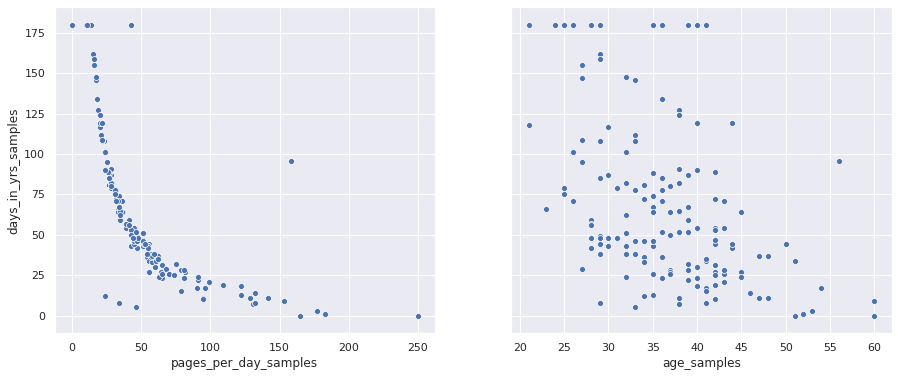

In [217]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,6))
sns.scatterplot(df.pages_per_day_samples,df.days_in_yrs_samples, ax=ax[0])
sns.scatterplot(df.age_samples, df.days_in_yrs_samples, ax=ax[1])
fig.show()

#### Observamos que la relacion entre days_in_yrs_samples y pages_per_day_samples es el de una funcion racional, es decir de la forma y = A/X + B entonces procedemos a transformarla para obtener la relacion entre estas 2 features de forma lineal y poder modelar esta relacion con una regresion lineal

#### Tambien eliminamos la feature age_samples porque observamos que no tiene correlacion con days_in_yrs_samples

In [218]:
del df['age_samples']

## Removemos outliers

### Los outliers son observaciones dentro de una muestra de datos que no es consistente con el resto. Hay puntos que escapan de esta relacion al estar muy lejos del centro. 

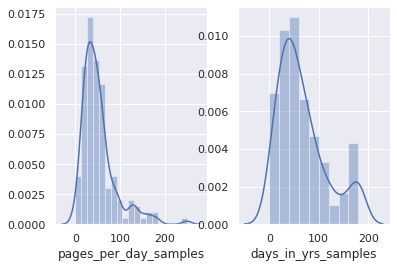

In [219]:
fig, ax = plt.subplots(1,2)
sns.distplot(df.pages_per_day_samples, ax=ax[0])
sns.distplot(df.days_in_yrs_samples, ax=ax[1])
fig.show()

In [220]:
q = df['pages_per_day_samples'].quantile(0.95)
df = df[df['pages_per_day_samples'] < q]

In [221]:
q = df['days_in_yrs_samples'].quantile(0.95)
df = df[df['days_in_yrs_samples'] < q]

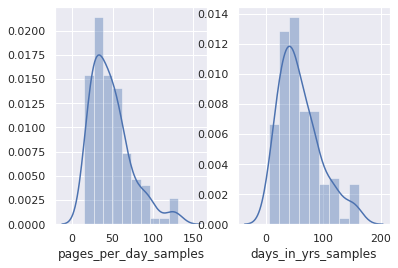

In [222]:
fig, ax = plt.subplots(1,2)
sns.distplot(df.pages_per_day_samples, ax=ax[0])
sns.distplot(df.days_in_yrs_samples, ax=ax[1])
fig.show()

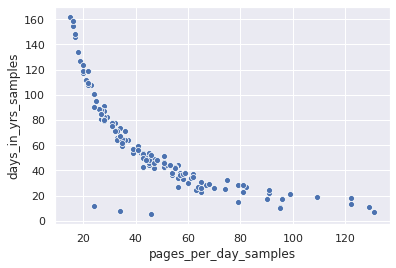

In [223]:
sns.scatterplot(df.pages_per_day_samples, df.days_in_yrs_samples)

### Se puede observar que estan quedando 3 outliers mas en el dataset. Por esta razon decidimos buscarlos manualmente y eliminarlos.

In [224]:
df[(df['days_in_yrs_samples'] < 20) & (df['pages_per_day_samples'] < 60)]

,pages_per_day_samples,days_in_yrs_samples
13,46,5
16,34,8
145,24,12


### Se puede observar que estas relaciones entre los datos no tienen sentido con el dataset en su totalidad. Tener solamente 46 paginas leidas con la cantidad de dias de vacaciones que se toma no representa un caso realista en los datos.

In [225]:
#elimino outliers a mano
df.drop([13,16,145], inplace=True)

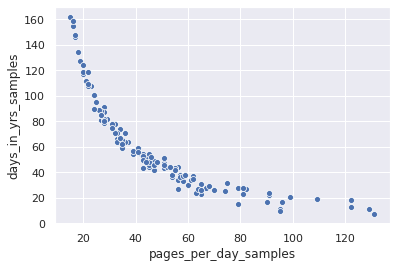

In [226]:
sns.scatterplot(df.pages_per_day_samples, df.days_in_yrs_samples)

### Ahora que tenemos los datos bien limpios podemos empezar a pensar si esta correlacion entre las paginas que leen por dia y los dias que se toman de licencia se puede transformar de forma lineal.

## linear transformation 

### Ya que pages_per_day_samples es inversamente proporcional a days_in_yrs_samples. Por esta razon no podemos mantener los datos que contengan cero. Decidimos agregarle un numero muy chiquito (epsilon) para poder seguir manteniendo estos valores y no tener que eliminarlos del dataset.

In [227]:
df['pages_per_day_samples'] = df['pages_per_day_samples'].replace(0,0.001)

In [228]:
# Averiguamos que la relacion entre 'pages_per_day_samples' y 'days_in_yrs_samples' tienen la forma y = 1/Ax + B
df['pages_per_day_samples_transf'] = 1 / (df.pages_per_day_samples)

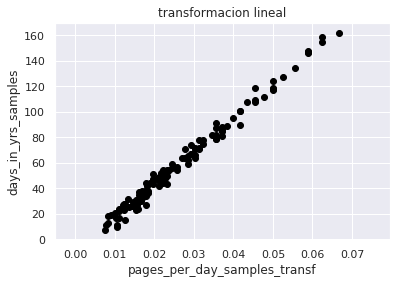

In [229]:
plt.scatter(df.pages_per_day_samples_transf, df.days_in_yrs_samples,  color='black')
plt.xlabel("pages_per_day_samples_transf")
plt.ylabel("days_in_yrs_samples")
plt.title("transformacion lineal")
plt.show()

### Observamos que pudimos transformar la relacion de pages_per_day_samples y days_in_yrs_sample en una relacion lineal

## Entrenamos modelo 

In [230]:
def print_model_statistics(regr, y_test, y_pred):

    # The coefficients
    print('Coefficients: ', regr.coef_)

    # The intercept_ 
    print('Intercept (Y axis when X = 0): ', regr.intercept_)

    # The mean squared error
    print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))

    # The coefficient of determination: 1 is perfect prediction
    r2 = r2_score(y_test, y_pred)
    print('Coefficient of determination: %.2f' % r2)
    
    # Adjusted r2
    n = X_test.shape[0]
    p = X_test.shape[1]
    adjusted_r2 = 1 - (1-r2) * (n-1)/(n-p-1)
    print('Adjusted r2: %.2f' % adjusted_r2)
    
    #explained_variance_score
    print('explained_variance_score: %.2f' % explained_variance_score(y_test, y_pred))

In [231]:
X = df[[
    'pages_per_day_samples_transf'
       ]]
y = df.days_in_yrs_samples

seed = 42
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

regr = LinearRegression().fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [232]:
print_model_statistics(regr, y_test, y_pred)

Coefficients:  [2603.9588694]
Intercept (Y axis when X = 0):  -9.294970958161564
Mean squared error: 20.39
Coefficient of determination: 0.98
Adjusted r2: 0.98
explained_variance_score: 0.98


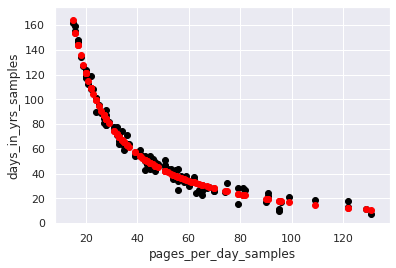

In [233]:
fc = 2603/(df.pages_per_day_samples) + -9.2
plt.scatter(df.pages_per_day_samples, df.days_in_yrs_samples,  color='black')
plt.scatter(df.pages_per_day_samples, fc, color='red')
plt.xlabel("pages_per_day_samples")
plt.ylabel("days_in_yrs_samples")
plt.show()

In [234]:
q = df['pages_per_day_samples'].quantile(0.90)
df = df[df['pages_per_day_samples'] < q]

q = df['days_in_yrs_samples'].quantile(0.90)
df = df[df['days_in_yrs_samples'] < q]

In [235]:
print_model_statistics(regr, y_test, y_pred)

Coefficients:  [2603.9588694]
Intercept (Y axis when X = 0):  -9.294970958161564
Mean squared error: 20.39
Coefficient of determination: 0.98
Adjusted r2: 0.98
explained_variance_score: 0.98


In [236]:
#ejemplo de uso

def transformar_valor(pages_per_day_samples):
 return 1/pages_per_day_samples

pages_per_day_samples = 100
x = transformar_valor(pages_per_day_samples)
regr.predict([[x]])

array([16.74461774])

La funcion que representa la relacion entre pages_per_day_samples y days_in_yrs_samples es: 
#### days_in_yrs_samples = 2603/(df.pages_per_day_samples) + -9.2
debido a que pages_per_day_samples es inversamente proporcional podemos observar que si un obrero lee muy pocas hojas por dia, al leer mas hojas, la cantidad de licencias que se toma bajara rapidamente. Asi mismo , los obreros que ya leen muchas paginas por dia no presentaran una significativa baja en las licencias tomadas si estos leen mas hojas